In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 4.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.5/895.5 KB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import random

In [3]:
phenotype = [random.randrange(1, 50, 1) for i in range(7)]
 
# printing result
print ("Random phenotype: " +  str(phenotype))

Random phenotype: [1, 37, 15, 11, 24, 46, 19]


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

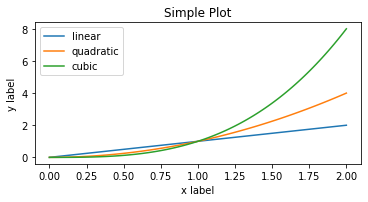

In [5]:
x = np.linspace(0, 2, 100)  # Sample data.

# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(x, x, label='linear')  # Plot some data on the axes.
ax.plot(x, x**2, label='quadratic')  # Plot more data on the axes...
ax.plot(x, x**3, label='cubic')  # ... and some more.
ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend();  # Add a legend.


In [6]:
def mutation(phenotype, mutation):
    mutation_rate = 1/len(phenotype) if mutation < 0 else mutation
    new_phenotype = []
    for value in phenotype:
        new_phenotype.append(random.randrange(1, 50) if random.random() < mutation_rate else value)
    return new_phenotype

In [7]:
print ("Original phenotype: " +  str(phenotype))
mutant = mutation(phenotype, 0.5)
print ("Mutated phenotype: " +  str(mutant))

Original phenotype: [1, 37, 15, 11, 24, 46, 19]
Mutated phenotype: [1, 37, 42, 11, 13, 46, 19]


In [8]:
def recombination(phenotype_1, phenotype_2):
    crossover_point = random.randrange(1, len(phenotype_1), 1)
    child_1 = phenotype_1[:crossover_point] + phenotype_2[crossover_point:]
    child_2 = phenotype_2[:crossover_point] + phenotype_1[crossover_point:]
    return child_1, child_2

In [9]:
partner_1 = [0, 0, 0, 0, 0, 0, 0]
partner_2 = [1, 1, 1, 1, 1, 1, 1]
child_1, child_2 = recombination(partner_1, partner_2)
print ("Child 1 phenotype: " +  str(child_1))
print ("Child 2 phenotype: " +  str(child_2))

Child 1 phenotype: [0, 0, 0, 0, 0, 0, 1]
Child 2 phenotype: [1, 1, 1, 1, 1, 1, 0]


In [10]:
class Individual:
    def __init__(self, genom):
        self.genom = genom
        self.fitness_score = 0

In [11]:
x = Individual([1, 2, 3, 4, 5])
print ("X genom: " + str(x.genom))
print ("X fitness: " + str(x.fitness_score))
x.fitness_score = 15
print ("X fitness: " + str(x.fitness_score))

X genom: [1, 2, 3, 4, 5]
X fitness: 0
X fitness: 15


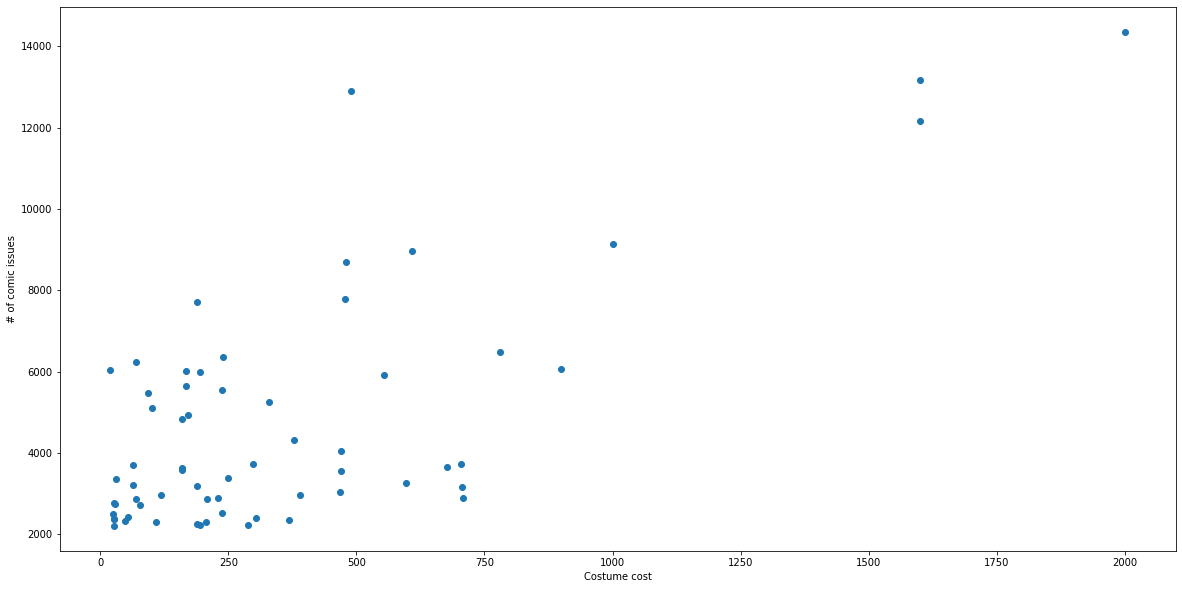

In [42]:
import csv
x = []
y = []
with open('data.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        x.append(int(row[0]))
        y.append(int(row[1]))

plt.rcParams['figure.figsize'] = [20, 10]


plt.scatter(x,y,marker="o")
plt.xlabel("Costume cost")
plt.ylabel("# of comic issues")
plt.show()